In [152]:
import numpy as np

class State:
    def __init__(self, vehicle_length, position, heading_angle, steering_angle, position_bounds=[[None, None], [None, None]], ang_bounds=[None, None], st_ang_bounds=[None, None]):
        self.position       = position  # Center of front axle [x, y]
        self.heading_angle  = heading_angle
        self.steering_angle = steering_angle

        self.position_bounds = position_bounds
        self.ang_bounds = ang_bounds
        self.st_ang_bounds = st_ang_bounds

        self.vehicle_length = vehicle_length

    @staticmethod
    def fromRawState(arr):
        return State(0, [arr[0], arr[1]], arr[2], arr[3])
        
    def update(self, velocity, steering_rate, dT):
        """,
        [x, y, 𝜃, 𝛿], 𝜃 is heading angle, 𝛿 is steering angle. Our inputs are [𝑣, 𝜑], 𝑣 is velocity, 𝜑 is steering rate.

        x_dot = v * cos(𝛿 + 𝜃)
        y_dot = v * sin(𝛿 + 𝜃)
        𝜃_dot = v / R = v / (L/sin(𝛿)) = v * sin(𝛿)/L
        𝛿_dot = 𝜑
        """

        self.steering_angle += steering_rate * dT
        heading_dot = velocity * np.sin(self.steering_angle) / self.vehicle_length
        self.heading_angle += heading_dot * dT
        x_dot = velocity * np.cos(self.heading_angle + self.steering_angle)
        y_dot = velocity * np.sin(self.heading_angle + self.steering_angle)

        self.position[0] += x_dot * dT
        self.position[1] += y_dot * dT

        # Enforce constraints
        if self.position_bounds[0][0] is not None:
            self.position[0] = max(self.position_bounds[0][0], self.position[0])
        if self.position_bounds[0][1] is not None:
            self.position[0] = min(self.position_bounds[0][1], self.position[0])
        if self.position_bounds[1][0] is not None:
            self.position[1] = max(self.position_bounds[1][0], self.position[1])
        if self.position_bounds[1][1] is not None:
            self.position[1] = min(self.position_bounds[1][1], self.position[1])

        if self.ang_bounds[0] is not None:
            self.heading_angle = max(self.ang_bounds[0], self.heading_angle)
        if self.ang_bounds[1] is not None:
            self.heading_angle = min(self.ang_bounds[1], self.heading_angle)

        if self.st_ang_bounds[0] is not None:
            self.steering_angle = max(self.st_ang_bounds[0], self.steering_angle)
        if self.st_ang_bounds[1] is not None:
            self.steering_angle = min(self.st_ang_bounds[1], self.steering_angle)

    def copy(self):
        return State(self.vehicle_length, self.position.copy(), self.heading_angle, self.steering_angle, self.position_bounds, self.ang_bounds, self.st_ang_bounds)

    def updated_state(self, actions, dT):
        actions = np.reshape(actions, (-1, 2))
        new_state = self.copy()
        for i in actions:
            new_state.update(i[0], i[1], dT)

        return new_state

    def raw_state(self):
        return [self.position[0], self.position[1], self.heading_angle, self.steering_angle]

    def check_bounds(self):
        if self.position_bounds[0][0] is not None and self.position[0] < self.position_bounds[0][0]:
            return False
        if self.position_bounds[0][1] is not None and self.position[0] > self.position_bounds[0][1]:
            return False
        if self.position_bounds[1][0] is not None and self.position[1] < self.position_bounds[1][0]:
            return False
        if self.position_bounds[1][1] is not None and self.position[1] > self.position_bounds[1][1]:
            return False
        
        if self.ang_bounds[0] is not None and self.heading_angle < self.ang_bounds[0]:
            return False
        if self.ang_bounds[1] is not None and self.heading_angle > self.ang_bounds[1]:
            return False
        
        if self.st_ang_bounds[0] is not None and self.steering_angle < self.st_ang_bounds[0]:
            return False
        if self.st_ang_bounds[1] is not None and self.steering_angle > self.st_ang_bounds[1]:
            return False
        
        return True

    def check_obstacles(self, obstacles):
        for obstacle in obstacles:
            distance = ((self.position[0] - obstacle[0])**2 + (self.position[1] - obstacle[1])**2)**.5
            if distance < obstacle[2]:
                return 1

        return 0

In [153]:
from scipy.optimize import minimize, NonlinearConstraint

class Optimizer:
    def __init__(self, initial_state, waypoints, dT, per_state_cost_function, final_state_cost_function, goal, obstacles, input_bounds, additional_constraints=lambda x: 0):
        self.state = initial_state
        self.waypoints = waypoints
        self.state_cost = per_state_cost_function
        self.fstate_cost = final_state_cost_function
        self.obstacles = obstacles
        self.goal = goal
        self.dT = dT
        self.additional_constraints = additional_constraints
        self.input_bounds = input_bounds

    def cost(self, x):
        waypoint_weight = 1
        goal_weight = .1

        x = np.reshape(x, (-1, 2))
        through_waypoint = float('inf')

        state = self.state.copy()

        dist_to_waypoint = ((state.position[0] - self.waypoints[0].position[0])**2 + (state.position[1] - self.waypoints[0].position[1])**2)**.5
        if dist_to_waypoint < through_waypoint:
            through_waypoint = dist_to_waypoint

        cost = 0
        for i in x:
            state.update(i[0], i[1], self.dT)

            dist_to_waypoint = ((state.position[0] - self.waypoints[0].position[0])**2 + (state.position[1] - self.waypoints[0].position[1])**2)**.5
            if dist_to_waypoint < through_waypoint:
                through_waypoint = dist_to_waypoint

            for obstacle in self.obstacles:
                distance = ((state.position[0] - obstacle[0])**2 + (state.position[1] - obstacle[1])**2)**.5
                if distance < obstacle[2]:
                    cost += 10000000 * obstacle[2]/distance

        distance_to_goal = ((state.position[0] - self.goal.position[0])**2 + (state.position[1] - self.goal.position[1])**2)**.5
        cost += distance_to_goal * goal_weight
        cost += through_waypoint * waypoint_weight

            # cost += .2 * self.state_cost(state, self.obstacles, self.goal)
            # cost += 1 * self.state_cost(state, [], self.waypoints[0])
            
        # cost += .2 * self.state_cost(state, self.obstacles, self.goal) + self.fstate_cost(state, self.goal)
        # cost += 1 * self.state_cost(state, [], self.waypoints[0]) + .2 * self.fstate_cost(state, self.waypoints[0])

        return cost

    # def constraints(self, x):
    #     state = self.state.copy()
    #     x = np.reshape(x, (-1, 2))

    #     cost = 0
    #     for i in x:
    #         state.update(i[0], i[1], self.dT)
    #         cost += (not state.check_bounds() * 1)
    #         cost += state.check_obstacles(self.obstacles)

    #     return cost

    def calculate_optimal_input(self, initial_guess, N):
        # N actions
        # N+1 states
        actions = np.array( [initial_guess for _ in range(N)] )
        actions = actions.flatten()

        bounds = []

        for _ in range(N):
            bounds.extend(self.input_bounds)
        
        # Minimize the cost function
        result = minimize(self.cost, actions, bounds=bounds)
        
        optimal_inputs = result.x
        return optimal_inputs

    

In [154]:
def dist(a: State, b):
    return ((a.position[0] - b[0])**2 + (a.position[1] - b[1])**2)**.5

def per_state_cost_function(state: State, obstacles, goal: State):
    cost = 0

    # Add cost for distance to goal
    x_dist = (goal.position[0] - state.position[0]) ** 2
    y_dist = (goal.position[1] - state.position[1]) ** 2

    cost += (x_dist + y_dist) ** .5

    # Add cost for bounds
    if state.position_bounds[0][0] is not None and state.position[0] < state.position_bounds[0][0]:
        cost += 100 * state.position_bounds[0][0] - state.position[0]
    if state.position_bounds[0][1] is not None and state.position[0] > state.position_bounds[0][1]:
        cost += 100 * state.position[0] - state.position_bounds[0][1]
    if state.position_bounds[1][0] is not None and state.position[1] < state.position_bounds[1][0]:
        cost += 100 * state.position_bounds[1][0] - state.position[1]
    if state.position_bounds[1][1] is not None and state.position[1] > state.position_bounds[1][1]:
        cost += 100 * state.position[1] - state.position_bounds[1][1]

    if state.ang_bounds[0] is not None and state.heading_angle < state.ang_bounds[0]:
        cost += 100 * state.ang_bounds[0] - state.heading_angle
    if state.ang_bounds[1] is not None and state.heading_angle > state.ang_bounds[1]:
        cost += 100 * state.heading_angle - state.ang_bounds[1]

    if state.st_ang_bounds[0] is not None and state.steering_angle < state.st_ang_bounds[0]:
        cost += 100 * state.st_ang_bounds[0] - state.steering_angle
    if state.st_ang_bounds[1] is not None and state.steering_angle > state.st_ang_bounds[1]:
        cost += 100 * state.steering_angle - state.st_ang_bounds[1]

    for obstacle in obstacles:
        distance = dist(state, obstacle)
        if distance <= obstacle[2]:
            cost += 10000000 * obstacle[2]/distance

    return cost

def final_state_cost_function(state, goal):
    cost = 0

    # Add cost for distance to goal
    x_dist = (goal.position[0] - state.position[0]) ** 2
    y_dist = (goal.position[1] - state.position[1]) ** 2

    cost += x_dist
    cost += y_dist
    
    # if goal.velx is not None:
    #     vx_dist = (goal.velx - state.velx) ** 2
    # else:
    #     vx_dist = 0

    # if goal.vely is not None:
    #     vy_dist = (goal.vely - state.vely) ** 2
    # else:
    #     vy_dist = 0

    return cost * 1000
    

In [155]:
# initial_state = State(0, 0, 0, 0, velx_bounds=(-5, 5), vely_bounds=(-5, 5))
# goal_state = State(5, 10, 0, 0, velx_bounds=(-5, 5), vely_bounds=(-5, 5))

# obstacles = [[2.5, 7.5, 1], [5.0, 3.0, 1], [3.0, 3.0, 1], [7.5, 7.5, 1]]
# waypoints = [[2, 5, None, None], [4, 6, None, None], [goal_state.x, goal_state.y, goal_state.velx, goal_state.vely]]
# dT = .1
# N = 30

# optimizer = Optimizer(initial_state, [], dT, per_state_cost_function, final_state_cost_function, goal_state, obstacles, (-3, 3))
# optimal_inputs = optimizer.calculate_optimal_input([2/dT/N, 5/dT/N], N)

initial_state = State(1, [0, 0], 0, 0, position_bounds=[[-10, 10], [-10, 10]], ang_bounds=[None, None], st_ang_bounds=[-np.pi/3, np.pi/3])
goal_state = State(1, [5, 5], None, None, position_bounds=[[-10, 10], [-10, 10]], ang_bounds=[None, None], st_ang_bounds=[-np.pi/3, np.pi/3])

obstacles = [[2, 2.5, 1], [3, 1, 1], [3.5, 3.5, 1]]
waypoints = [[1.5, 4, None, None], [3, 5, None, None], [goal_state.position[0], goal_state.position[1], None, None]]
# waypoints = [[goal_state.position[0], goal_state.position[1], None, None]]

dT = .1
N = 20

# optimizer = Optimizer(initial_state, waypoints, dT, per_state_cost_function, final_state_cost_function, goal_state, obstacles, [[-3, 3], [-np.pi/4, np.pi/4]])
# optimal_inputs = optimizer.calculate_optimal_input([2/dT/N, 0], N)

In [158]:
import numpy as np
import time

time_spent = 0
iters_spent = 0

range_ = .5

total_inputs = []
state = initial_state.copy()

def within_range(state, waypoint):
    dist_ = ((waypoint[0] - state.position[0])**2 + (waypoint[1] - state.position[1])**2)**.5 
    print("DIST", dist_)

    return dist_ <= range_

while len(waypoints) > 0:
    start_time = time.time()
    optimizer = Optimizer(state.copy(), [State.fromRawState(way) for way in waypoints], dT, per_state_cost_function, final_state_cost_function, goal_state, obstacles, [[0, 3], [-np.pi/3, np.pi/3]])
    # optimal_inputs = optimizer.calculate_optimal_input([2/dT/N, 0], N)

    # Set initial velocity and angle based on next waypoint

    current_to_waypoint_vector = np.array([waypoints[0][0] - state.position[0], waypoints[0][1] - state.position[1]])

    current_to_waypoint_needed_velocity = np.linalg.norm(current_to_waypoint_vector) / dT / N
    current_to_waypoint_needed_steering_angle = (np.arctan2(current_to_waypoint_vector[1], current_to_waypoint_vector[0]) - state.heading_angle) / dT / N

    # print("INITIAL INPUT: ", [current_to_waypoint_needed_velocity, current_to_waypoint_needed_steering_angle])

    optimal_inputs = optimizer.calculate_optimal_input(
        [current_to_waypoint_needed_velocity, current_to_waypoint_needed_steering_angle],
        N
    )[:8]
    # optimal_inputs = optimizer.calculate_optimal_input(
    #     [0, 0],
    #     N
    # )[:16]
    end_time = time.time()

    time_spent += end_time - start_time
    iters_spent += 1

    total_inputs.extend(optimal_inputs)
    state = state.updated_state(optimal_inputs, dT)

    print(state.raw_state())

    if within_range(state, waypoints[0]):
        if within_range(state, waypoints[-1]):
            print("WITHIN RANGE")
            break
        waypoints.pop(0)

print(total_inputs)
print("FINAL STATE: ", state.raw_state())
print("AVG TIME: ", time_spent / iters_spent)

[1.1071445283456771, 0.40934884487017525, 0.26202486838516603, 0.34572647661397765]
DIST 3.6120785068217836
[1.4688521287328045, 0.9826427548661456, 0.6154402127637615, 0.7152875109732939]
DIST 3.017518009001146
[1.4067006400554174, 1.5837723129025543, 1.0503729709808793, 0.8411490255749255]
DIST 2.418028330368017
[1.1755616560764581, 1.9127247995623962, 1.3685152054303975, 0.762471760494339]
DIST 2.1123394616797957
[1.0373870446313478, 2.2261850262877525, 1.5336941747297468, 0.3672139750002143]
DIST 1.833147650201887
[0.9551603716107185, 2.573403741397711, 1.6098564127588457, 0.1231984887642374]
DIST 1.5270976084459758
[0.9388240800959416, 2.8807748541535236, 1.6123978223109678, -0.05593222823691337]
DIST 1.252031684972562
[0.9673418327452694, 3.187821454717489, 1.5771072799291277, -0.15509590268977566]
DIST 0.9712665507266192
[1.018853614458937, 3.398166765742401, 1.5300819577306677, -0.2573112872230994]
DIST 0.7705226058826512
[1.0898056603756092, 3.574084716358911, 1.47256554874097

[[0, 0, 0, 0], [0.29776098316059985, 0.03658410730403271, 0.02817983700495405, 0.09407147532272014], [0.5874415793864116, 0.11459149266117807, 0.08215281491288498, 0.18089488273665633], [0.860864290610056, 0.2380419725594417, 0.1603607912097976, 0.26374021783891644], [1.1071445283456771, 0.40934884487017525, 0.26202486838516603, 0.34572647661397765], [1.2723869698204062, 0.575892720104302, 0.3597379868690263, 0.42958266223466274], [1.3828027445679463, 0.7395737889360132, 0.4577686149204068, 0.5195674797594221], [1.4436427566425618, 0.8796588409100423, 0.5459056756466378, 0.6151628144169674], [1.4688521287328045, 0.9826427548661456, 0.6154402127637615, 0.7152875109732939], [1.4853957898923411, 1.1359530332739696, 0.7198124160295427, 0.7434901922930861], [1.4807899163202767, 1.289331427068463, 0.8270471600554973, 0.77376962612505], [1.4545589194869717, 1.439705469537493, 0.9372138330361904, 0.8062831282299108], [1.4067006400554174, 1.5837723129025543, 1.0503729709808793, 0.84114902557492

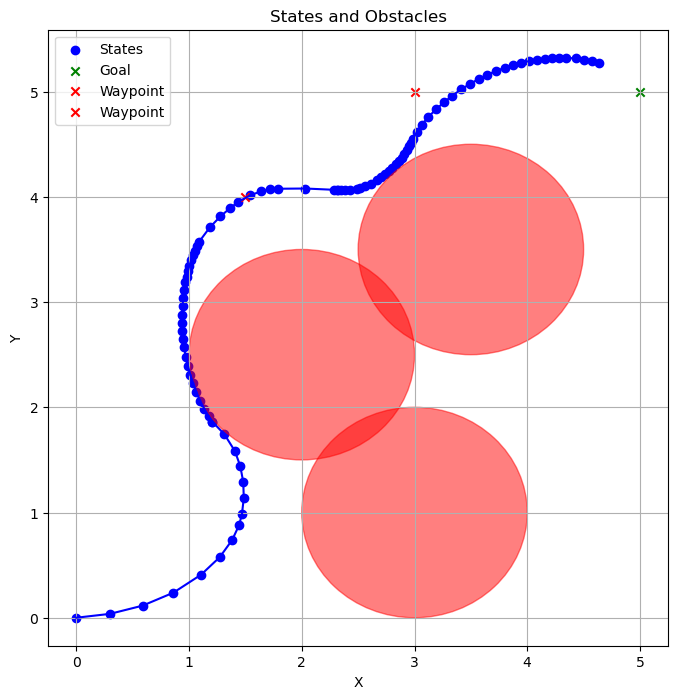

In [157]:
import matplotlib.pyplot as plt

# Calculate optimal inputs
new_actions = np.reshape(total_inputs, (-1, 2))

# current_to_waypoint_needed_velocity = np.linalg.norm(current_to_waypoint_vector) / dT / N
# current_to_waypoint_needed_steering_angle = np.arctan2(current_to_waypoint_vector[1], current_to_waypoint_vector[0]) / dT / N

# new_actions = np.reshape([3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016], (-1, 2))

waypoints = [[1.5, 4, None, None], [3, 5, None, None], [goal_state.position[0], goal_state.position[1], None, None]]

state = initial_state.copy()
states = [state.raw_state()]
for action in new_actions:
    state.update(action[0], action[1], dT)
    states.append(state.raw_state())

print(states)

x = [state[0] for state in states]
y = [state[1] for state in states]

# Plot states and obstacles
plt.figure(figsize=(8, 8))
plt.scatter(x, y, color='blue', label='States')
for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='red', alpha=0.5)
    plt.gca().add_patch(circle)

# Plot the goal
plt.scatter(goal_state.position[0], goal_state.position[1], color='green', marker='x', label='Goal')

# Plot the waypoints
for waypoint in waypoints[:-1]:
    plt.scatter(waypoint[0], waypoint[1], color='red', marker='x', label='Waypoint')

# Plot lines between states
for i in range(len(x) - 1):
    plt.plot([x[i], x[i+1]], [y[i], y[i+1]], color='blue')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('States and Obstacles')
plt.legend()
plt.grid(True)
plt.show()
